In [81]:
import torch

In [82]:

# 加载DINO v2模型
dinov2_vitl14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')
dinov2_vitl14

Using cache found in C:\Users\jimaz/.cache\torch\hub\facebookresearch_dinov2_main


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-23): 24 x NestedTensorBlock(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )


In [83]:
from torchsummary import summary
summary(dinov2_vitl14, (3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
├─PatchEmbed: 1-1                        [-1, 256, 1024]           --
|    └─Conv2d: 2-1                       [-1, 1024, 16, 16]        603,136
|    └─Identity: 2-2                     [-1, 256, 1024]           --
├─ModuleList: 1                          []                        --
|    └─NestedTensorBlock: 2-3            [-1, 257, 1024]           --
|    |    └─LayerNorm: 3-1               [-1, 257, 1024]           2,048
|    |    └─MemEffAttention: 3-2         [-1, 257, 1024]           4,198,400
|    |    └─LayerScale: 3-3              [-1, 257, 1024]           1,024
|    |    └─LayerNorm: 3-4               [-1, 257, 1024]           2,048
|    |    └─Mlp: 3-5                     [-1, 257, 1024]           8,393,728
|    |    └─LayerScale: 3-6              [-1, 257, 1024]           1,024
|    └─NestedTensorBlock: 2-4            [-1, 257, 1024]           --
|    |    └─LayerNorm: 3-7               [-1, 257, 102

Layer (type:depth-idx)                   Output Shape              Param #
├─PatchEmbed: 1-1                        [-1, 256, 1024]           --
|    └─Conv2d: 2-1                       [-1, 1024, 16, 16]        603,136
|    └─Identity: 2-2                     [-1, 256, 1024]           --
├─ModuleList: 1                          []                        --
|    └─NestedTensorBlock: 2-3            [-1, 257, 1024]           --
|    |    └─LayerNorm: 3-1               [-1, 257, 1024]           2,048
|    |    └─MemEffAttention: 3-2         [-1, 257, 1024]           4,198,400
|    |    └─LayerScale: 3-3              [-1, 257, 1024]           1,024
|    |    └─LayerNorm: 3-4               [-1, 257, 1024]           2,048
|    |    └─Mlp: 3-5                     [-1, 257, 1024]           8,393,728
|    |    └─LayerScale: 3-6              [-1, 257, 1024]           1,024
|    └─NestedTensorBlock: 2-4            [-1, 257, 1024]           --
|    |    └─LayerNorm: 3-7               [-1, 257, 102

In [84]:
from PIL import Image
import os
from torchvision import transforms
import torch

patch_nums_sqrt = 30
transform = transforms.Compose([           
                transforms.Resize((14*patch_nums_sqrt, 14*patch_nums_sqrt)),
                transforms.ToTensor()
                ])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def get_features(folder_path):
  total_features  = []
  with torch.no_grad():
    for img_path in os.listdir(folder_path):
      img_path = os.path.join(folder_path, img_path)
      img = Image.open(img_path).convert('RGB')
      img_t = transform(img).to(device)
      
      features_dict = dinov2_vitl14.forward_features(img_t.unsqueeze(0))
      features = features_dict['x_norm_patchtokens']
      total_features.append(features)

  total_features = torch.cat(total_features, dim=0)
  return total_features

folder_path = os.path.join(os.getcwd(), 'images')
total_features = get_features(folder_path)
total_features.shape #num_images, num_patches, feature_dim

torch.Size([4, 900, 1024])

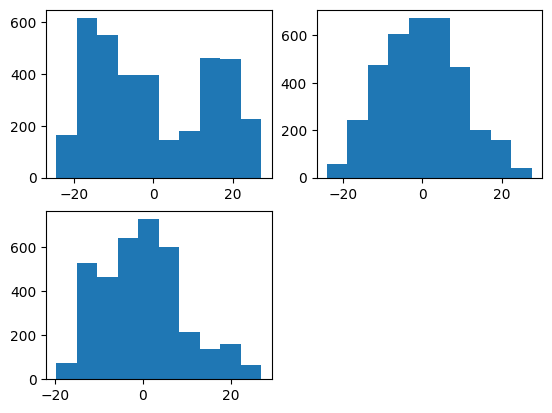

In [85]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
# 将维度转为(num_images * num_patches, feature_dim)
feat_dim = total_features.shape[-1]
image_nums = total_features.shape[0]
total_features = total_features.reshape(image_nums * patch_nums_sqrt * patch_nums_sqrt, feat_dim)
# Convert to numpy array
total_features = total_features.cpu().numpy()

pca = PCA(n_components=3)
pca.fit(total_features)
pca_features = pca.transform(total_features)

# Visualize PCA components for finding a proper threshold
plt.subplot(2, 2, 1)
plt.hist(pca_features[:, 0])
plt.subplot(2, 2, 2)
plt.hist(pca_features[:, 1])
plt.subplot(2, 2, 3)
plt.hist(pca_features[:, 2])
plt.show()

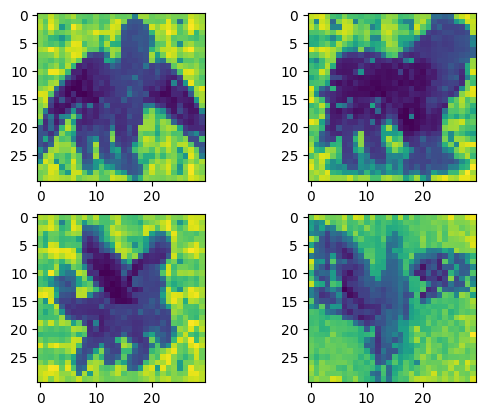

In [86]:
# min-max缩放
pca_features[:, 0] = (pca_features[:, 0] - pca_features[:, 0].min()) / (pca_features[:, 0].max() - pca_features[:, 0].min())

# 绘制第一个主成分图像
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features[i*patch_nums_sqrt*patch_nums_sqrt : (i+1)*patch_nums_sqrt*patch_nums_sqrt, 0].reshape(patch_nums_sqrt, patch_nums_sqrt))

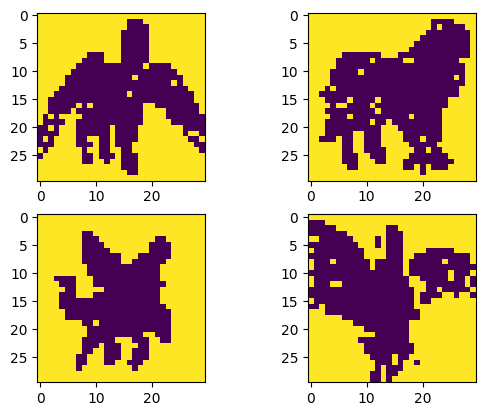

In [87]:
# 使用第一主成分进行背景分割
pca_features_bg = pca_features[:, 0] > 0.35 # from first histogram
pca_features_fg = ~pca_features_bg

# 绘制背景分割结果
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features_bg[i * patch_nums_sqrt * patch_nums_sqrt: (i+1) * patch_nums_sqrt * patch_nums_sqrt].reshape(patch_nums_sqrt, patch_nums_sqrt))

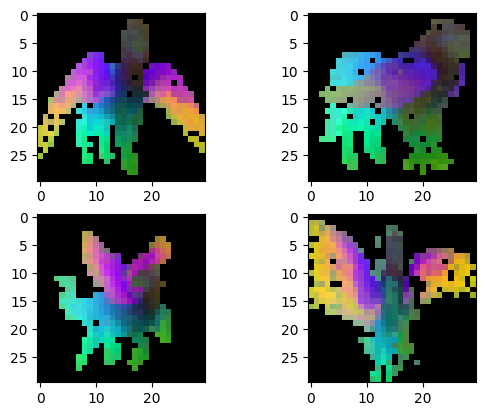

In [88]:
# 使用第二主成分对前景进行可视化
pca.fit(total_features[pca_features_fg]) 
pca_features_left = pca.transform(total_features[pca_features_fg])

for i in range(3):
    # min_max scaling
    pca_features_left[:, i] = (pca_features_left[:, i] - pca_features_left[:, i].min()) / (pca_features_left[:, i].max() - pca_features_left[:, i].min())

pca_features_rgb = pca_features.copy()
pca_features_rgb[pca_features_bg] = 0
pca_features_rgb[pca_features_fg] = pca_features_left

# 绘制前景分割结果
pca_features_rgb = pca_features_rgb.reshape(image_nums, patch_nums_sqrt, patch_nums_sqrt, 3)
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features_rgb[i])
plt.show()